# competition House Prices - Linear Regresion

In [277]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin

import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
import dagshub
import warnings

### Configuration & Setup

In [278]:
# Define constants
TEST_SIZE = 0.2
RANDOM_STATE = 42
N_SPLITS_KFOLD = 5
OUTLIER_Z_THRESHOLD = 3
CORRELATION_THRESHOLD = 0.7
N_FEATURES_RFE = 25
mlflow_active = True

### MLflow & DagsHub Setup

In [279]:
try:
    # Initialize Dagshub only if the repo info is correct
    dagshub.init(repo_owner='konstantine25b', repo_name='Machine_learning', mlflow=True)
    print("DagsHub initialized successfully.")
    mlflow.set_experiment("House Prices Experiment - assignment 1")
    print(f"MLflow experiment set to: {mlflow.get_experiment_by_name('House Prices Experiment - assignment 1').name}")
except Exception as e:
    print(f"Could not initialize DagsHub or set MLflow experiment: {e}")
    print("Proceeding without MLflow tracking.")
    # Set a dummy client to avoid errors if tracking fails
    mlflow_active = False
else:
    mlflow_active = True

Initialized MLflow to track repo "konstantine25b/Machine_learning"

Repository konstantine25b/Machine_learning initialized!

DagsHub initialized successfully.
MLflow experiment set to: House Prices Experiment - assignment 1


# Data Loading

In [280]:
try:
    df_train_full = pd.read_csv('./house-prices/train.csv')
    print("Train data loaded successfully.")
    print(f"Initial training data shape: {df_train_full.shape}")
except FileNotFoundError:
    print("Error: train.csv not found in ./house-prices/. Please ensure the file exists.")
    exit() # Exit if data is missing
    
df_train_full.head

Train data loaded successfully.
Initial training data shape: (1460, 81)


<bound method NDFrame.head of         Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Util

### Initial Data Split

In [281]:
y_original = df_train_full['SalePrice']
X_original = df_train_full.drop('SalePrice', axis=1)

X_train, X_val, y_train, y_val = train_test_split(
    X_original, y_original, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
print(f"Training data size: X_train - {X_train.shape}, y_train - {y_train.shape}")
print(f"Validation data size: X_val - {X_val.shape}, y_val - {y_val.shape}")


Training data size: X_train - (1168, 80), y_train - (1168,)
Validation data size: X_val - (292, 80), y_val - (292,)


Plotting distribution of first 5 numerical features...


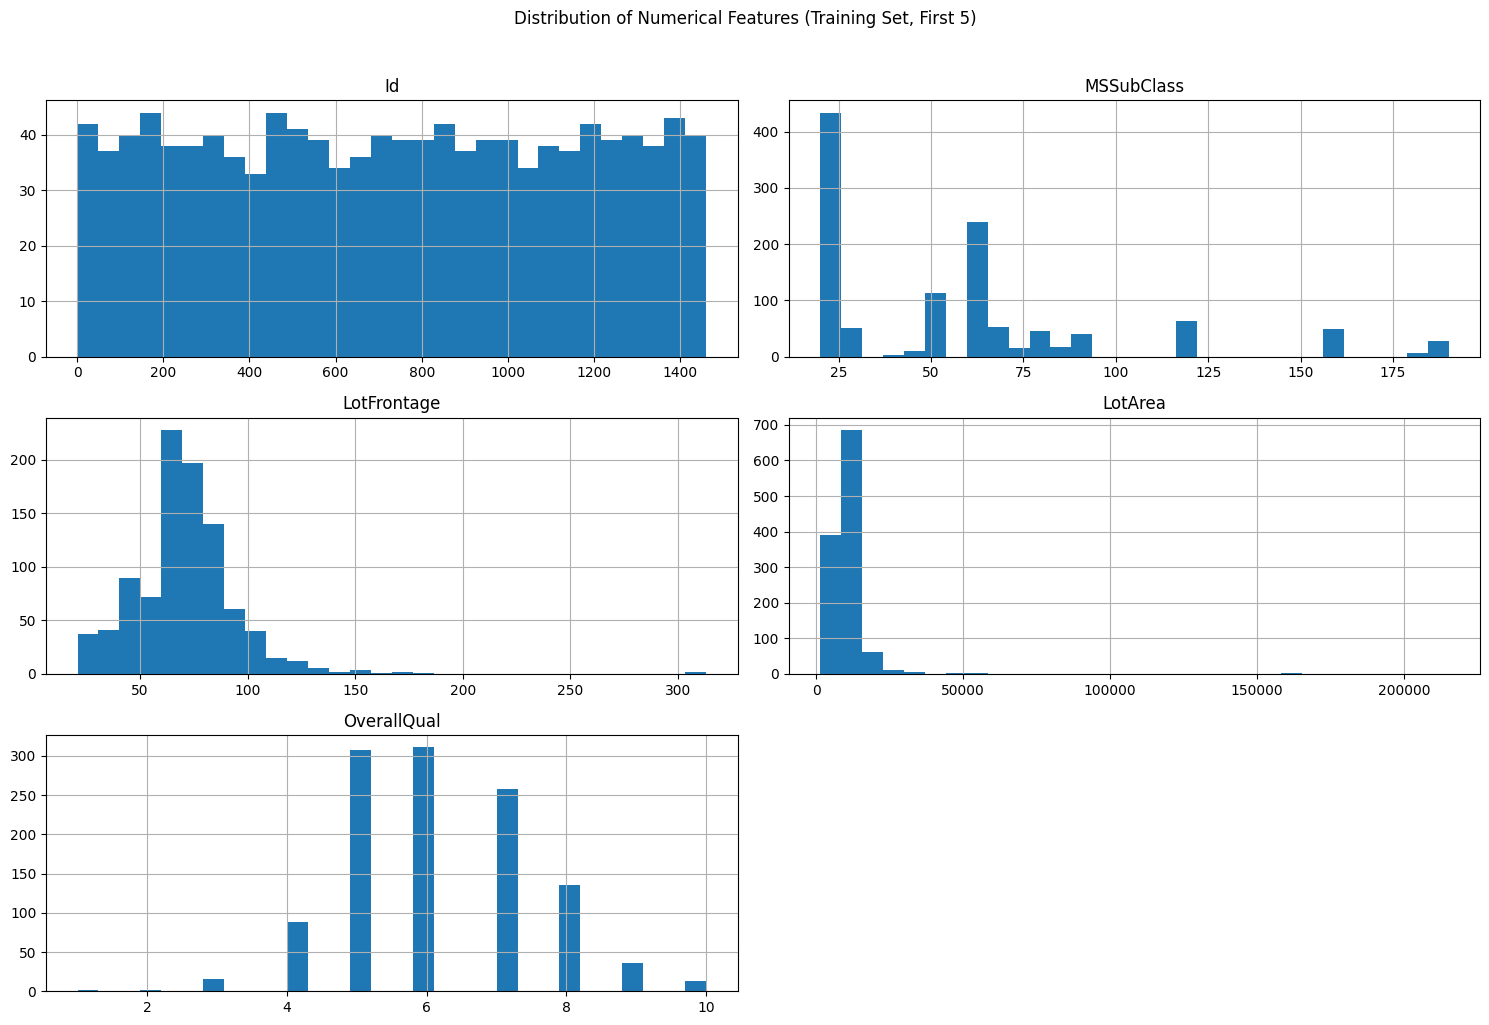

In [282]:
X_train_numerical_eda = X_train.select_dtypes(exclude=['object'])
if not X_train_numerical_eda.empty:
    print("Plotting distribution of first 5 numerical features...")
    X_train_numerical_eda.iloc[:, :min(5, X_train_numerical_eda.shape[1])].hist(figsize=(15, 10), bins=30)
    plt.suptitle("Distribution of Numerical Features (Training Set, First 5)", y=1.02)
    plt.tight_layout()
    plt.show()

Plotting distribution of first 5 categorical features...


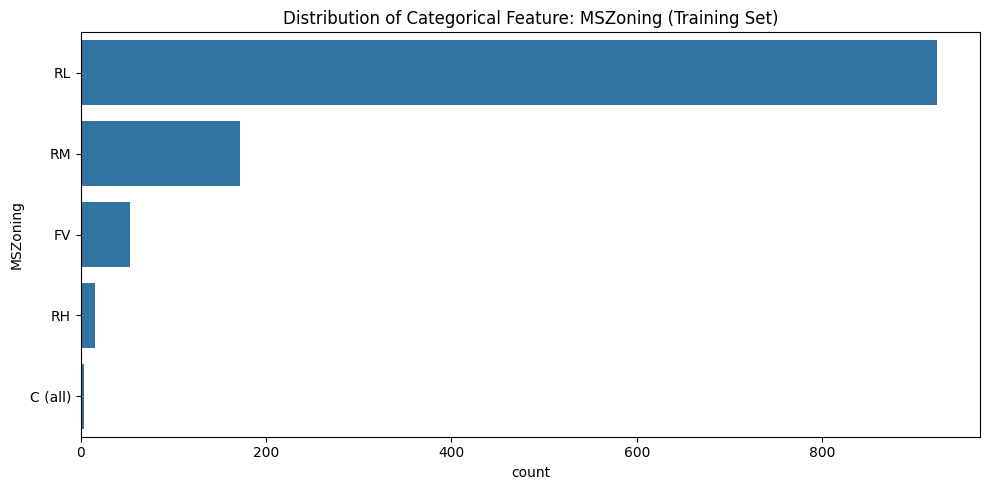

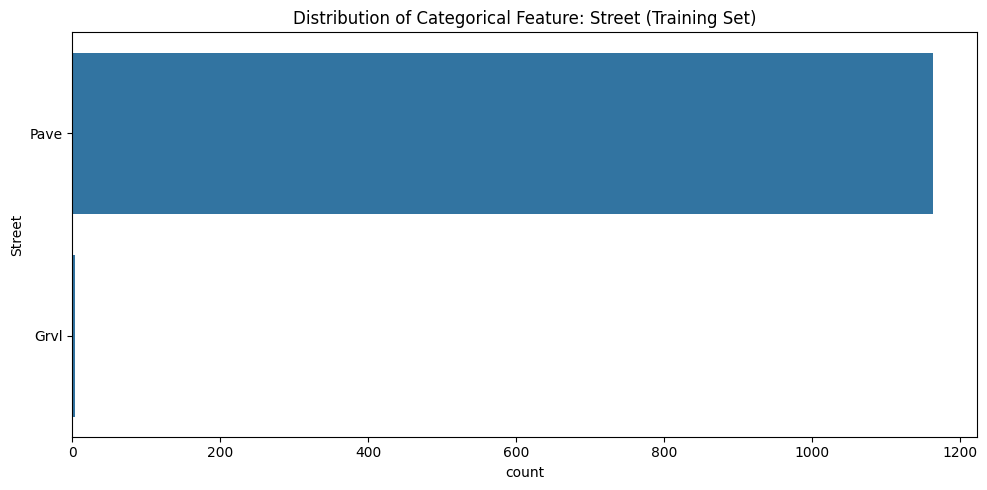

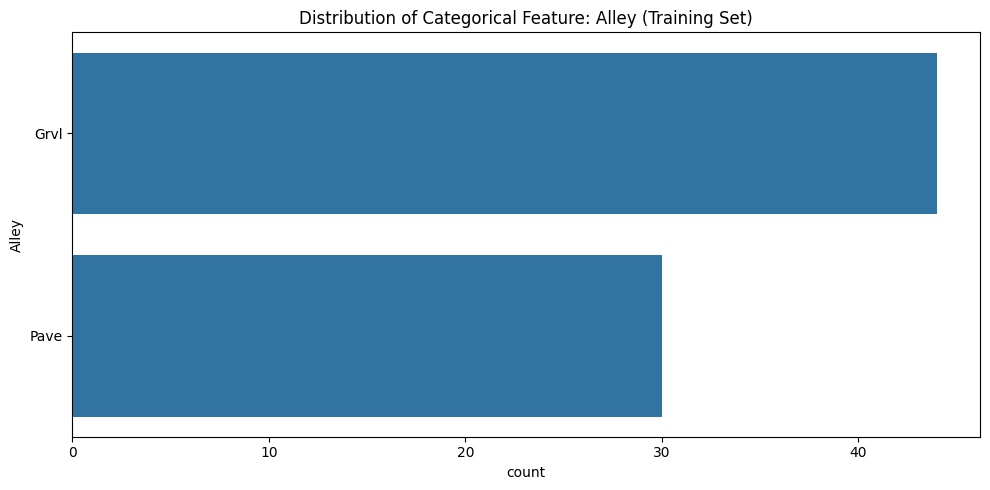

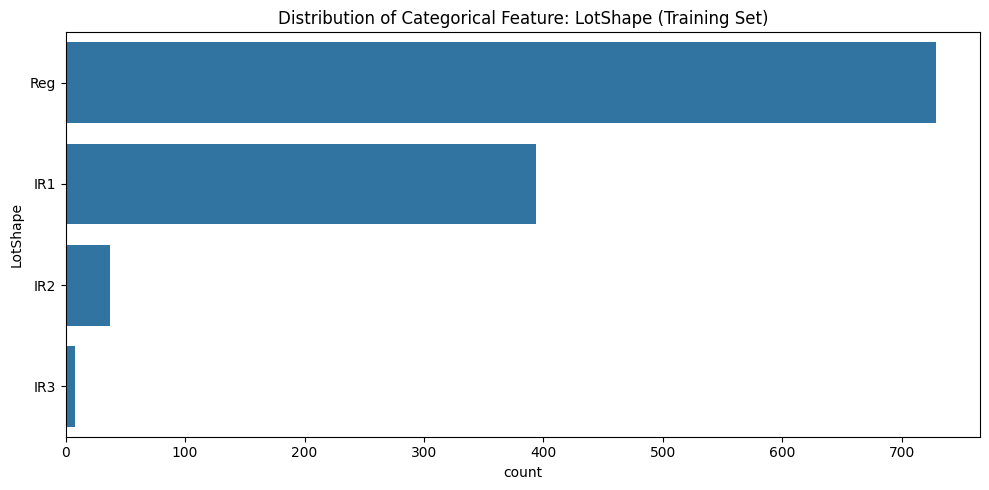

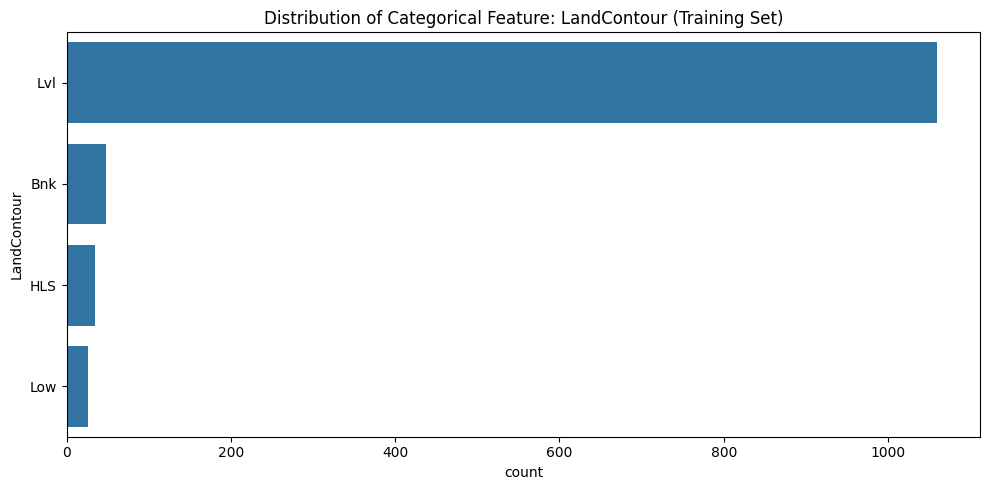

In [283]:
# Count of Categorical Features
X_train_categorical_eda = X_train.select_dtypes(include=['object'])
if not X_train_categorical_eda.empty:
    print("Plotting distribution of first 5 categorical features...")
    for i, col in enumerate(X_train_categorical_eda.columns[:min(5, len(X_train_categorical_eda.columns))]):
        plt.figure(figsize=(10, 5))
        sns.countplot(data=X_train_categorical_eda, y=col, order = X_train_categorical_eda[col].value_counts().index) # Use y for horizontal plot if many categories
        plt.title(f"Distribution of Categorical Feature: {col} (Training Set)")
        plt.tight_layout()
        plt.show()

Plotting distribution of the target variable (SalePrice)...


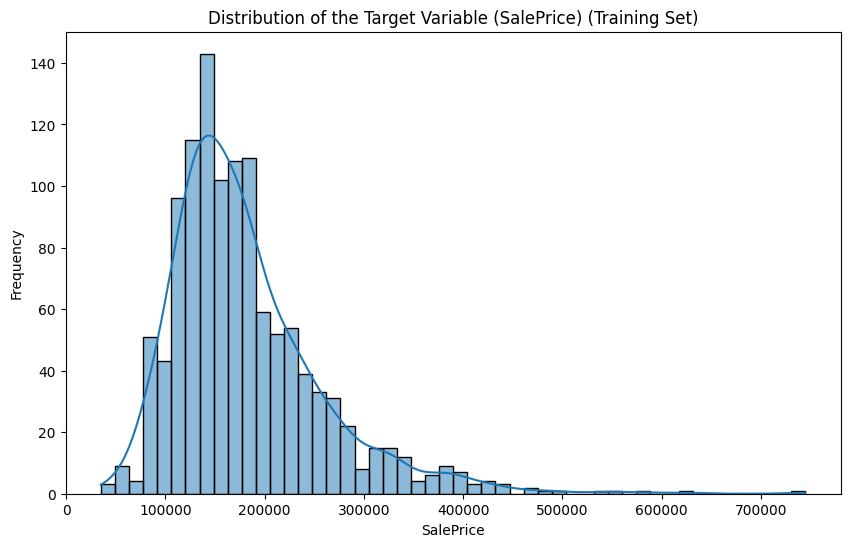

In [284]:
# Distribution of the Target Variable
print("Plotting distribution of the target variable (SalePrice)...")
plt.figure(figsize=(10, 6))
sns.histplot(y_train, kde=True, bins=50)
plt.title("Distribution of the Target Variable (SalePrice) (Training Set)")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()

# Data Cleaning 

### Handling outliers

In [285]:
print("\n--- Outlier Handling (Target Variable: SalePrice) ---")
print(f"Original training size: {X_train.shape[0]} samples")


--- Outlier Handling (Target Variable: SalePrice) ---
Original training size: 1168 samples


Number of potential outliers in SalePrice (Z-score > 3): 17
Potential outlier values in SalePrice (Training Set):
278     415298
664     423000
1142    424870
389     426000
496     430000
349     437154
473     440000
527     446261
1373    466500
185     475000
798     485000
178     501837
769     538000
440     555000
803     582933
1169    625000
1182    745000
Name: SalePrice, dtype: int64


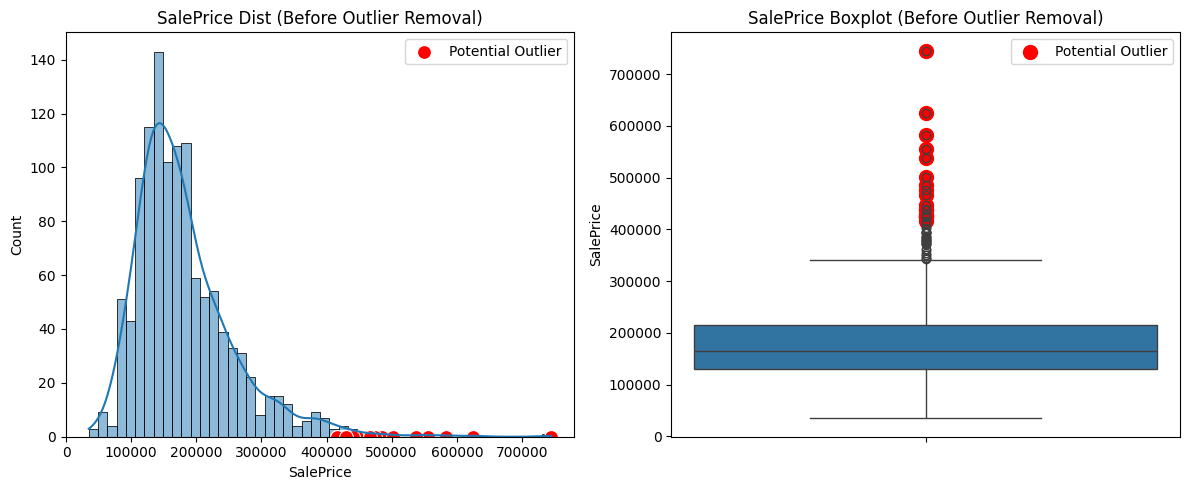

Training data size after removing SalePrice outliers: X_train - (1151, 80), y_train - (1151,)


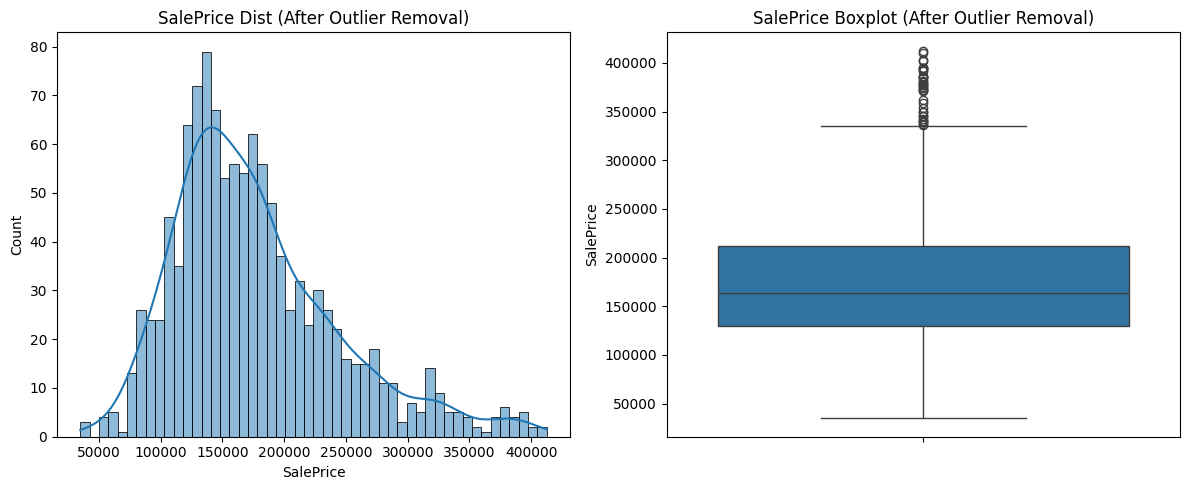

In [286]:
z_score = np.abs(stats.zscore(y_train))
outlier_indices = np.where(z_score > OUTLIER_Z_THRESHOLD)[0]
outlier_original_indices = y_train.iloc[outlier_indices].index # Get original df indices
num_outliers = len(outlier_indices)

print(f"Number of potential outliers in SalePrice (Z-score > {OUTLIER_Z_THRESHOLD}): {num_outliers}")

if num_outliers > 0:
    print("Potential outlier values in SalePrice (Training Set):")
    print(y_train.iloc[outlier_indices].sort_values())

    # Visualize outliers
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(y_train, kde=True, bins=50)
    sns.scatterplot(x=y_train.iloc[outlier_indices], y=[0]*num_outliers, color='red', marker='o', s=100, label='Potential Outlier')
    plt.title("SalePrice Dist (Before Outlier Removal)")
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.boxplot(y=y_train)
    plt.scatter(y=y_train.iloc[outlier_indices], x=[0]*num_outliers, color='red', marker='o', s=100, label='Potential Outlier')
    plt.title("SalePrice Boxplot (Before Outlier Removal)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Remove outliers
    X_train = X_train.drop(index=outlier_original_indices)
    y_train = y_train.drop(index=outlier_original_indices)
    print(f"Training data size after removing SalePrice outliers: X_train - {X_train.shape}, y_train - {y_train.shape}")

    # Visualize after removal
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(y_train, kde=True, bins=50)
    plt.title("SalePrice Dist (After Outlier Removal)")

    plt.subplot(1, 2, 2)
    sns.boxplot(y=y_train)
    plt.title("SalePrice Boxplot (After Outlier Removal)")
    plt.tight_layout()
    plt.show()

else:
    print("No significant outliers detected in SalePrice based on the Z-score threshold.")


### Feature Engineering

In [287]:
# --- Feature Engineering Function ---
# Encapsulates the creation of new features
def engineer_features(df):
    df_eng = df.copy()
    
    df_eng['TotalRemodYears'] = df_eng['YrSold'] - df_eng['YearRemodAdd']
    df_eng['TotalBuiltAge'] = df_eng['YrSold'] - df_eng['YearBuilt']
    df_eng['LivingAreaRatio'] = df_eng['GrLivArea'] / (df_eng['LotArea'] + 1e-6) 
    df_eng['BasementSurfaceRatio'] = df_eng['TotalBsmtSF'] / (df_eng['LotArea'] + 1e-6) 

    df_eng['HasGarage'] = (df_eng['GarageArea'] > 0).astype(int)
    df_eng['HasBasement'] = (df_eng['TotalBsmtSF'] > 0).astype(int)
    
    return df_eng

# Use FunctionTransformer to integrate into pipeline
feature_engineer = FunctionTransformer(engineer_features, validate=False) # validate=False if output columns differ


### Correlation handling

In [288]:
class HighCorrelationRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.7):
        self.threshold = threshold
        self.cols_to_drop_ = None # Columns to drop, learned during fit

    def fit(self, X, y=None):
        # Ensure input is a DataFrame to access column names and dtypes
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        numerical_cols = X.select_dtypes(include=np.number).columns
        if not numerical_cols.empty:
            corr_matrix = X[numerical_cols].corr().abs()
            upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
            # Find columns where ANY correlation in its column (in the upper triangle) exceeds threshold
            self.cols_to_drop_ = [column for column in upper.columns if any(upper[column] > self.threshold)]
            print(f"\n[HighCorrelationRemover] Identified {len(self.cols_to_drop_)} columns to drop with threshold > {self.threshold}:")
            print(self.cols_to_drop_)
        else:
             self.cols_to_drop_ = []
             print("[HighCorrelationRemover] No numerical columns found to check for correlation.")
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X) # Convert if needed, though column names might be lost if input wasn't DF
        if self.cols_to_drop_:
            X_transformed = X.drop(columns=self.cols_to_drop_, errors='ignore')
            print(f"[HighCorrelationRemover] Dropped columns. Shape before: {X.shape}, Shape after: {X_transformed.shape}")
            return X_transformed
        print("[HighCorrelationRemover] No columns to drop.")
        return X

# Preprocessing

In [289]:
# Identify column types AFTER potential outlier removal
numerical_cols_initial = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols_initial = X_train.select_dtypes(include=['object']).columns.tolist()


In [290]:
# Define numerical pipeline steps
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])

In [291]:
# Define categorical pipeline steps
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse=False for easier handling downstream
])

In [292]:
initial_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols_initial),
        ('cat', categorical_transformer, categorical_cols_initial)
    ],
    remainder='passthrough' # Keep any columns not specified (e.g., Id if not dropped) - adjust if needed
)

In [293]:
full_pipeline = Pipeline(steps=[
    ('feature_engineering', feature_engineer),
    ('initial_processing', initial_preprocessor),
    ('numerical_imputer', SimpleImputer(strategy='median')),
    ('categorical_imputer', ColumnTransformer([ # Impute categorical, keep others
        ('cat_impute', SimpleImputer(strategy='most_frequent'), lambda df: df.select_dtypes(include='object').columns)
    ], remainder='passthrough')),
    ('correlation_remover', HighCorrelationRemover(threshold=CORRELATION_THRESHOLD)), # Remove correlation *after* imputation but *before* encoding/scaling
    ('onehot_encoder', ColumnTransformer([ # OneHotEncode remaining categoricals
         ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), lambda df: df.select_dtypes(include='object').columns)
     ], remainder='passthrough', verbose_feature_names_out=False)), # Prevent prefix collision if run multiple times
    # Final Scaler will be added *after* RFE selection
])

### Applying Preprocessing Steps

In [294]:
# 1. Feature Engineering
X_train_eng = feature_engineer.fit_transform(X_train)
X_val_eng = feature_engineer.transform(X_val)
print(f"Shape after Feature Engineering: {X_train_eng.shape}")


Shape after Feature Engineering: (1151, 86)


### Handling missing values (NA filling)

In [295]:
# --- Show Starting NAs ---
print("\n--- Checking NAs before Imputation ---")
# Identify column types after engineering
numerical_cols_eng_train = X_train_eng.select_dtypes(include=np.number).columns
categorical_cols_eng_train = X_train_eng.select_dtypes(include='object').columns
numerical_cols_eng_val = X_val_eng.select_dtypes(include=np.number).columns
categorical_cols_eng_val = X_val_eng.select_dtypes(include='object').columns

# Calculate and print NA counts for TRAINING set
na_num_train_before = X_train_eng[numerical_cols_eng_train].isnull().sum().sum()
print(f"NAs in Numerical columns (Train) BEFORE imputation: {na_num_train_before}")

if not categorical_cols_eng_train.empty:
    na_cat_train_before = X_train_eng[categorical_cols_eng_train].isnull().sum().sum()
    print(f"NAs in Categorical columns (Train) BEFORE imputation: {na_cat_train_before}")
else:
    print("No categorical columns found (Train) to check for NAs before imputation.")

# Calculate and print NA counts for VALIDATION set
na_num_val_before = X_val_eng[numerical_cols_eng_val].isnull().sum().sum()
print(f"NAs in Numerical columns (Validation) BEFORE imputation: {na_num_val_before}")

if not categorical_cols_eng_val.empty:
    na_cat_val_before = X_val_eng[categorical_cols_eng_val].isnull().sum().sum()
    print(f"NAs in Categorical columns (Validation) BEFORE imputation: {na_cat_val_before}")
else:
    print("No categorical columns found (Validation) to check for NAs before imputation.")
print("------------------------------------")



--- Checking NAs before Imputation ---
NAs in Numerical columns (Train) BEFORE imputation: 285
NAs in Categorical columns (Train) BEFORE imputation: 5871
NAs in Numerical columns (Validation) BEFORE imputation: 61
NAs in Categorical columns (Validation) BEFORE imputation: 1541
------------------------------------


In [296]:

# 2. Imputation (Numerical) - Keep as DataFrame
print("Step 2: Handling NA - Numerical Imputation (Median)...") # Added print statement
num_imputer = SimpleImputer(strategy='median')
numerical_cols_eng = X_train_eng.select_dtypes(include=np.number).columns
# Fit on training data ONLY
num_imputer.fit(X_train_eng[numerical_cols_eng])
# Transform both train and validation
X_train_eng[numerical_cols_eng] = num_imputer.transform(X_train_eng[numerical_cols_eng])
X_val_eng[numerical_cols_eng] = num_imputer.transform(X_val_eng[numerical_cols_eng])
print("Numerical imputation done.")
# Verify remaining NAs in numerical columns (should be 0)
print(f"Remaining NAs in numerical train columns after imputation: {X_train_eng[numerical_cols_eng].isnull().sum().sum()}")


# 3. Imputation (Categorical) - Keep as DataFrame
print("Step 3: Handling NA - Categorical Imputation (Most Frequent)...") # Added print statement
cat_imputer = SimpleImputer(strategy='most_frequent')
categorical_cols_eng = X_train_eng.select_dtypes(include='object').columns
if not categorical_cols_eng.empty:
    # Fit on training data ONLY
    cat_imputer.fit(X_train_eng[categorical_cols_eng])
    # Transform both train and validation
    X_train_eng[categorical_cols_eng] = cat_imputer.transform(X_train_eng[categorical_cols_eng])
    X_val_eng[categorical_cols_eng] = cat_imputer.transform(X_val_eng[categorical_cols_eng])
    print("Categorical imputation done.")
    # Verify remaining NAs in categorical columns (should be 0)
    print(f"Remaining NAs in categorical train columns after imputation: {X_train_eng[categorical_cols_eng].isnull().sum().sum()}")

else:
    print("No categorical columns found after feature engineering for imputation.")


Step 2: Handling NA - Numerical Imputation (Median)...
Numerical imputation done.
Remaining NAs in numerical train columns after imputation: 0
Step 3: Handling NA - Categorical Imputation (Most Frequent)...
Categorical imputation done.
Remaining NAs in categorical train columns after imputation: 0


### Correlation removing

In [297]:
# 4. Correlation Removal - Keep as DataFrame
corr_remover = HighCorrelationRemover(threshold=CORRELATION_THRESHOLD)
X_train_uncorr = corr_remover.fit_transform(X_train_eng)
X_val_uncorr = corr_remover.transform(X_val_eng) # Use fitted remover
print(f"Shape after Correlation Removal: {X_train_uncorr.shape}")



[HighCorrelationRemover] Identified 7 columns to drop with threshold > 0.7:
['1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea', 'TotalRemodYears', 'TotalBuiltAge', 'BasementSurfaceRatio']
[HighCorrelationRemover] Dropped columns. Shape before: (1151, 86), Shape after: (1151, 79)
[HighCorrelationRemover] Dropped columns. Shape before: (292, 86), Shape after: (292, 79)
Shape after Correlation Removal: (1151, 79)


### One hot Encoding

In [298]:
# 5. One-Hot Encoding - This converts to numerical
categorical_cols_uncorr = X_train_uncorr.select_dtypes(include=['object']).columns
numerical_cols_uncorr = X_train_uncorr.select_dtypes(exclude=['object']).columns

if not categorical_cols_uncorr.empty:
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    # Fit on Training data
    X_train_encoded_part = pd.DataFrame(encoder.fit_transform(X_train_uncorr[categorical_cols_uncorr]),
                                        columns=encoder.get_feature_names_out(categorical_cols_uncorr),
                                        index=X_train_uncorr.index)
    # Transform Validation data
    X_val_encoded_part = pd.DataFrame(encoder.transform(X_val_uncorr[categorical_cols_uncorr]),
                                      columns=encoder.get_feature_names_out(categorical_cols_uncorr),
                                      index=X_val_uncorr.index)

    # Combine numerical and encoded categorical parts
    X_train_processed_rfe = pd.concat([X_train_uncorr[numerical_cols_uncorr], X_train_encoded_part], axis=1)
    X_val_processed_rfe = pd.concat([X_val_uncorr[numerical_cols_uncorr], X_val_encoded_part], axis=1)
    print("One-hot encoding done.")
else:
    print("No categorical columns found for One-Hot Encoding.")
    X_train_processed_rfe = X_train_uncorr.copy() # All numerical
    X_val_processed_rfe = X_val_uncorr.copy()

# Ensure column alignment between train and val (can happen if OHE creates different columns due to rare values)
train_cols = X_train_processed_rfe.columns
val_cols = X_val_processed_rfe.columns
missing_in_val = set(train_cols) - set(val_cols)
for c in missing_in_val:
    X_val_processed_rfe[c] = 0
missing_in_train = set(val_cols) - set(train_cols)
for c in missing_in_train:
     X_train_processed_rfe[c] = 0 # Should not happen if fitted correctly, but good practice
X_val_processed_rfe = X_val_processed_rfe[train_cols] # Order columns the same


print(f"Shape of data prepared for RFE: {X_train_processed_rfe.shape}")
print(f"Number of features before RFE: {X_train_processed_rfe.shape[1]}")


One-hot encoding done.
Shape of data prepared for RFE: (1151, 285)
Number of features before RFE: 285


### RFE

In [299]:
selected_features = {} # Dictionary to store selected features for each scaler type

for scaler_name, scaler_obj in [('StandardScaler', StandardScaler()), ('MinMaxScaler', MinMaxScaler())]:
    print(f"\n--- Feature Selection using RFE with {scaler_name} ---")

    # Create a temporary pipeline for RFE: Scaler -> Estimator
    rfe_temp_pipeline = Pipeline([
        ('scaler', scaler_obj),
        ('estimator', LinearRegression()) # Base estimator for RFE rankings
    ])

    # RFE needs the estimator, not the pipeline directly in older sklearn versions.
    # Newer versions might accept pipeline directly. Let's fit the scaler first.
    # Scaler needed for RFE's internal coefficient evaluation if using Linear Regression directly
    X_train_scaled_for_rfe = scaler_obj.fit_transform(X_train_processed_rfe)
    # RFE uses the *coefficients* of the estimator. Scaling matters for Linear Regression coefficients.
    rfe_selector = RFE(
        estimator=LinearRegression(), # Use the base estimator
        n_features_to_select=N_FEATURES_RFE,
        step=1 # Remove one feature at a time
        # importance_getter='auto' # Let RFE determine importance (coef_ or feature_importances_)
    )

    # Fit RFE on the SCALED data
    print(f"Fitting RFE ({scaler_name}) to select {N_FEATURES_RFE} features...")
    rfe_selector.fit(X_train_scaled_for_rfe, y_train)

    # Get selected feature *names* from the original processed dataframe
    selected_mask = rfe_selector.support_
    selected_features[scaler_name] = X_train_processed_rfe.columns[selected_mask]

    print(f"Selected top {len(selected_features[scaler_name])} features using RFE ({scaler_name}):")
    print(list(selected_features[scaler_name]))

    # Create the final training and validation sets with *only* the selected features
    X_train_selected = X_train_processed_rfe[selected_features[scaler_name]]
    X_val_selected = X_val_processed_rfe[selected_features[scaler_name]]

    print(f"Shape of Training Set after RFE ({scaler_name}): {X_train_selected.shape}")
    print(f"Shape of Validation Set after RFE ({scaler_name}): {X_val_selected.shape}")

    # Store these selected dataframes for model training
    # We need to differentiate them based on which RFE run they came from
    globals()[f'X_train_selected_rfe_{scaler_name}'] = X_train_selected
    globals()[f'X_val_selected_rfe_{scaler_name}'] = X_val_selected



--- Feature Selection using RFE with StandardScaler ---
Fitting RFE (StandardScaler) to select 25 features...
Selected top 25 features using RFE (StandardScaler):
['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'Fireplaces', 'GarageCars', 'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Condition2_PosN', 'BldgType_1Fam', 'RoofMatl_ClyTile', 'Exterior1st_BrkFace', 'ExterQual_Ex', 'Foundation_PConc', 'BsmtQual_Ex', 'BsmtExposure_Gd', 'KitchenQual_Ex', 'Functional_Typ']
Shape of Training Set after RFE (StandardScaler): (1151, 25)
Shape of Validation Set after RFE (StandardScaler): (292, 25)

--- Feature Selection using RFE with MinMaxScaler ---
Fitting RFE (MinMaxScaler) to select 25 features...
Selected top 25 features using RFE (MinMaxScaler):
['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'KitchenAbvG

# Model Training and Evaluation 

In [300]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Define scoring metrics
scoring = ['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2']

class ModelTrainer:
    def __init__(self, models, param_grids, scoring, kf, mlflow_active=False):
        self.models = models
        self.param_grids = param_grids
        self.scoring = scoring
        self.kf = kf
        self.mlflow_active = mlflow_active

    def train_and_evaluate(self, rfe_scaler_name, X_train_sel, y_train, X_val_sel, y_val, selected_features):
        print(f"\n===== Evaluating Models on Features Selected by RFE ({rfe_scaler_name}) =====")

        # Determine the appropriate final scaler based on the RFE variant name
        final_scaler_obj = StandardScaler() if rfe_scaler_name == 'StandardScaler' else MinMaxScaler()

        # Iterate through each model
        for model_name, model_instance in self.models.items():
            print(f"\n--- Training {model_name} (RFE: {rfe_scaler_name}) ---")

            # Create the final model pipeline: Scaler -> Model
            model_pipeline = Pipeline(steps=[
                ('scaler', final_scaler_obj), # Apply the final scaling
                ('model', model_instance)
            ])

            # Get the parameter grid for the current model
            current_param_grid = self.param_grids.get(model_name, {})

            # Perform GridSearchCV
            grid_search = GridSearchCV(
                estimator=model_pipeline,
                param_grid=current_param_grid,
                scoring=self.scoring,
                cv=self.kf,
                n_jobs=-1, # Use all available CPU cores
                refit='neg_root_mean_squared_error',
                verbose=1 # Show progress
            )

            print(f"Running GridSearchCV for {model_name}...")
            grid_search.fit(X_train_sel, y_train)

            # --- Get Best Results from CV ---
            best_cv_rmse = -grid_search.best_score_ # Score is negative RMSE
            best_cv_mae = -grid_search.cv_results_['mean_test_neg_mean_absolute_error'][grid_search.best_index_]
            best_cv_r2 = grid_search.cv_results_['mean_test_r2'][grid_search.best_index_]
            best_params = grid_search.best_params_

            print(f"\nBest CV Results for {model_name} (RFE: {rfe_scaler_name}):")
            print(f"  Best CV RMSE: {best_cv_rmse:.4f}")
            print(f"  Best CV MAE:  {best_cv_mae:.4f}")
            print(f"  Best CV R2:   {best_cv_r2:.4f}")
            print(f"  Best Params:  {best_params}")

            # --- Evaluate Best Model on Training and Validation Sets ---
            best_model = grid_search.best_estimator_

            # Training Set Evaluation
            y_train_pred = best_model.predict(X_train_sel)
            train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
            train_mae = mean_absolute_error(y_train, y_train_pred)
            train_r2 = r2_score(y_train, y_train_pred)

            print(f"\nTraining Set Performance ({model_name}, RFE: {rfe_scaler_name}):")
            print(f"  Training RMSE: {train_rmse:.4f}")
            print(f"  Training MAE:  {train_mae:.4f}")
            print(f"  Training R2:   {train_r2:.4f}")

            # Validation Set Evaluation
            y_val_pred = best_model.predict(X_val_sel)
            val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
            val_mae = mean_absolute_error(y_val, y_val_pred)
            val_r2 = r2_score(y_val, y_val_pred)

            print(f"\nValidation Set Performance ({model_name}, RFE: {rfe_scaler_name}):")
            print(f"  Validation RMSE: {val_rmse:.4f}")
            print(f"  Validation MAE:  {val_mae:.4f}")
            print(f"  Validation R2:   {val_r2:.4f}")

            # --- MLflow Logging ---
            if self.mlflow_active:
                run_name = f"{model_name}_RFE_{rfe_scaler_name}"
                with mlflow.start_run(run_name=run_name, nested=True):
                    print(f"\nLogging results to MLflow for run: {run_name}")
                    # Log Tags
                    mlflow.set_tag("model_name", model_name)
                    mlflow.set_tag("rfe_variant", rfe_scaler_name)
                    mlflow.set_tag("final_scaler", type(final_scaler_obj).__name__)
                    mlflow.set_tag("feature_selection", "RFE")
                    mlflow.set_tag("n_features_selected", len(selected_features[rfe_scaler_name]))

                    # Log Parameters
                    mlflow.log_params(best_params)
                    mlflow.log_param("k_folds", self.kf.get_n_splits())
                    mlflow.log_param("outlier_z_threshold", OUTLIER_Z_THRESHOLD)
                    mlflow.log_param("correlation_threshold", CORRELATION_THRESHOLD)
                    mlflow.log_param("rfe_features_count", N_FEATURES_RFE)

                    # Log Metrics (CV)
                    mlflow.log_metric("best_cv_rmse", best_cv_rmse)
                    mlflow.log_metric("best_cv_mae", best_cv_mae)
                    mlflow.log_metric("best_cv_r2", best_cv_r2)

                    # Log Metrics (Training)
                    mlflow.log_metric("train_rmse", train_rmse)
                    mlflow.log_metric("train_mae", train_mae)
                    mlflow.log_metric("train_r2", train_r2)

                    # Log Metrics (Validation)
                    mlflow.log_metric("val_rmse", val_rmse)
                    mlflow.log_metric("val_mae", val_mae)
                    mlflow.log_metric("val_r2", val_r2)

                    # Log Model
                    # Create input example and signature for the model
                    # The input to the *logged* model is the data *before* the final scaling step in the pipeline
                    input_example = X_train_sel.head()
                    # The output is the prediction
                    output_example = pd.DataFrame(y_val_pred[:5], columns=["SalePrice_Predicted"])
                    signature = infer_signature(input_example, output_example)

                    mlflow.sklearn.log_model(
                        sk_model=best_model,
                        artifact_path=f"{model_name}_RFE_{rfe_scaler_name}_model",
                        signature=signature,
                        input_example=input_example.to_dict(orient='split') # Provide example as dict
                    )

                    # Log selected feature names as an artifact (optional but useful)
                    features_list_path = f"selected_features_rfe_{rfe_scaler_name}.txt"
                    with open(features_list_path, 'w') as f:
                        for feature in selected_features[rfe_scaler_name]:
                            f.write(f"{feature}\n")
                    mlflow.log_artifact(features_list_path)


# Evaluation of algorithms

In [301]:
print("\n--- Model Training and Evaluation ---")

# Define models to evaluate
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(random_state=RANDOM_STATE),
    "DecisionTree": DecisionTreeRegressor(random_state=RANDOM_STATE)
}

# Define parameter grids for GridSearchCV
param_grids = {
    "LinearRegression": {}, # No hyperparameters to tune for basic Linear Regression
    "Ridge": {
        'model__alpha': [0.1, 1.0, 10.0, 50.0, 100.0] # Regularization strength
    },
    "DecisionTree": {
        'model__max_depth': [3, 5, 7, 10],  # Limit the maximum depth of the tree
        'model__min_samples_split': [10, 20, 30, 50],  # Increase the minimum samples required to split a node
        'model__min_samples_leaf': [5, 10, 15, 20],  # Increase the minimum samples required at a leaf node
        'model__ccp_alpha': [0.0, 0.01, 0.02, 0.05, 0.1],  # Pruning parameter to remove less significant splits
        'model__max_features': ['sqrt', None], # Consider limiting the number of features to consider at each split
        'model__min_impurity_decrease': [0.0, 0.001] # Minimum decrease in impurity for a split
    }
}

# Define scoring metrics for GridSearchCV
scoring = ['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2']

# K-Fold cross-validation strategy
kf = KFold(n_splits=N_SPLITS_KFOLD, shuffle=True, random_state=RANDOM_STATE)



--- Model Training and Evaluation ---


In [ ]:
# Initialize the ModelTrainer class
model_trainer = ModelTrainer(models, param_grids, scoring, kf, mlflow_active)

# Iterate through each RFE variant (StandardScaler RFE, MinMaxScaler RFE)
for rfe_scaler_name in selected_features.keys():
    X_train_sel = globals()[f'X_train_selected_rfe_{rfe_scaler_name}']
    X_val_sel = globals()[f'X_val_selected_rfe_{rfe_scaler_name}']

    print(f"Shape of X_train_sel for {rfe_scaler_name}: {X_train_sel.shape}")
    print(f"Shape of y_train: {y_train.shape}")
    print(f"Shape of X_val_sel for {rfe_scaler_name}: {X_val_sel.shape}")
    print(f"Shape of y_val: {y_val.shape}")

    model_trainer.train_and_evaluate(rfe_scaler_name, X_train_sel, y_train, X_val_sel, y_val, selected_features)
print("\n--- Pipeline Execution Finished ---")

Shape of X_train_sel for StandardScaler: (1151, 25)
Shape of y_train: (1151,)
Shape of X_val_sel for StandardScaler: (292, 25)
Shape of y_val: (292,)

===== Evaluating Models on Features Selected by RFE (StandardScaler) =====

--- Training LinearRegression (RFE: StandardScaler) ---
Running GridSearchCV for LinearRegression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best CV Results for LinearRegression (RFE: StandardScaler):
  Best CV RMSE: 28771.0792
  Best CV MAE:  15476.4134
  Best CV R2:   0.7954
  Best Params:  {}

Training Set Performance (LinearRegression, RFE: StandardScaler):
  Training RMSE: 20795.0578
  Training MAE:  14333.9712
  Training R2:   0.9032

Validation Set Performance (LinearRegression, RFE: StandardScaler):
  Validation RMSE: 30131.7479
  Validation MAE:  17730.1345
  Validation R2:   0.8816

Logging results to MLflow for run: LinearRegression_RFE_StandardScaler


2025/04/07 17:59:37 WARNING mlflow.models.model: Failed to validate serving input example {
  "inputs": {
    "index": [
      254,
      1066,
      638,
      799,
      380
    ],
    "columns": [
      "LotArea",
      "OverallQual",
      "OverallCond",
      "YearBuilt",
      "YearRemodAdd",
      "BsmtFinSF1",
      "TotalBsmtSF",
      "GrLivArea",
      "Fireplaces",
      "GarageCars",
      "Neighborhood_Crawfor",
      "Neighborhood_NoRidge",
      "Neighborhood_NridgHt",
      "Neighborhood_Somerst",
      "Neighborhood_StoneBr",
      "Condition2_PosN",
      "BldgType_1Fam",
      "RoofMatl_ClyTile",
      "Exterior1st_BrkFace",
      "ExterQual_Ex",
      "Foundation_PConc",
      "BsmtQual_Ex",
      "BsmtExposure_Gd",
      "KitchenQual_Ex",
      "Functional_Typ"
    ],
    "data": [
      [
        8400.0,
        5.0,
        6.0,
        1957.0,
        1957.0,
        922.0,
        1314.0,
        1314.0,
        0.0,
        1.0,
        0.0,
        0.0,
    

🏃 View run LinearRegression_RFE_StandardScaler at: https://dagshub.com/konstantine25b/Machine_learning.mlflow/#/experiments/0/runs/0626e2bb318247128f8923581b9e7c8d
🧪 View experiment at: https://dagshub.com/konstantine25b/Machine_learning.mlflow/#/experiments/0

--- Training Ridge (RFE: StandardScaler) ---
Running GridSearchCV for Ridge...
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best CV Results for Ridge (RFE: StandardScaler):
  Best CV RMSE: 27978.0921
  Best CV MAE:  15608.5753
  Best CV R2:   0.8094
  Best Params:  {'model__alpha': 100.0}

Training Set Performance (Ridge, RFE: StandardScaler):
  Training RMSE: 21062.2025
  Training MAE:  14532.9699
  Training R2:   0.9007

Validation Set Performance (Ridge, RFE: StandardScaler):
  Validation RMSE: 31255.5923
  Validation MAE:  17988.3681
  Validation R2:   0.8726

Logging results to MLflow for run: Ridge_RFE_StandardScaler


2025/04/07 18:00:09 WARNING mlflow.models.model: Failed to validate serving input example {
  "inputs": {
    "index": [
      254,
      1066,
      638,
      799,
      380
    ],
    "columns": [
      "LotArea",
      "OverallQual",
      "OverallCond",
      "YearBuilt",
      "YearRemodAdd",
      "BsmtFinSF1",
      "TotalBsmtSF",
      "GrLivArea",
      "Fireplaces",
      "GarageCars",
      "Neighborhood_Crawfor",
      "Neighborhood_NoRidge",
      "Neighborhood_NridgHt",
      "Neighborhood_Somerst",
      "Neighborhood_StoneBr",
      "Condition2_PosN",
      "BldgType_1Fam",
      "RoofMatl_ClyTile",
      "Exterior1st_BrkFace",
      "ExterQual_Ex",
      "Foundation_PConc",
      "BsmtQual_Ex",
      "BsmtExposure_Gd",
      "KitchenQual_Ex",
      "Functional_Typ"
    ],
    "data": [
      [
        8400.0,
        5.0,
        6.0,
        1957.0,
        1957.0,
        922.0,
        1314.0,
        1314.0,
        0.0,
        1.0,
        0.0,
        0.0,
    

🏃 View run Ridge_RFE_StandardScaler at: https://dagshub.com/konstantine25b/Machine_learning.mlflow/#/experiments/0/runs/17800e19f0444041a9844479c9c439ed
🧪 View experiment at: https://dagshub.com/konstantine25b/Machine_learning.mlflow/#/experiments/0

--- Training DecisionTree (RFE: StandardScaler) ---
Running GridSearchCV for DecisionTree...
Fitting 5 folds for each of 1280 candidates, totalling 6400 fits

Best CV Results for DecisionTree (RFE: StandardScaler):
  Best CV RMSE: 31324.1219
  Best CV MAE:  21928.5774
  Best CV R2:   0.7749
  Best Params:  {'model__ccp_alpha': 0.0, 'model__max_depth': 10, 'model__max_features': None, 'model__min_impurity_decrease': 0.0, 'model__min_samples_leaf': 5, 'model__min_samples_split': 20}

Training Set Performance (DecisionTree, RFE: StandardScaler):
  Training RMSE: 20107.8892
  Training MAE:  14114.5548
  Training R2:   0.9095

Validation Set Performance (DecisionTree, RFE: StandardScaler):
  Validation RMSE: 42279.2565
  Validation MAE:  24362.

2025/04/07 18:00:41 WARNING mlflow.models.model: Failed to validate serving input example {
  "inputs": {
    "index": [
      254,
      1066,
      638,
      799,
      380
    ],
    "columns": [
      "LotArea",
      "OverallQual",
      "OverallCond",
      "YearBuilt",
      "YearRemodAdd",
      "BsmtFinSF1",
      "TotalBsmtSF",
      "GrLivArea",
      "Fireplaces",
      "GarageCars",
      "Neighborhood_Crawfor",
      "Neighborhood_NoRidge",
      "Neighborhood_NridgHt",
      "Neighborhood_Somerst",
      "Neighborhood_StoneBr",
      "Condition2_PosN",
      "BldgType_1Fam",
      "RoofMatl_ClyTile",
      "Exterior1st_BrkFace",
      "ExterQual_Ex",
      "Foundation_PConc",
      "BsmtQual_Ex",
      "BsmtExposure_Gd",
      "KitchenQual_Ex",
      "Functional_Typ"
    ],
    "data": [
      [
        8400.0,
        5.0,
        6.0,
        1957.0,
        1957.0,
        922.0,
        1314.0,
        1314.0,
        0.0,
        1.0,
        0.0,
        0.0,
    

🏃 View run DecisionTree_RFE_StandardScaler at: https://dagshub.com/konstantine25b/Machine_learning.mlflow/#/experiments/0/runs/024e335d60b54618b4b696432d9eeb04
🧪 View experiment at: https://dagshub.com/konstantine25b/Machine_learning.mlflow/#/experiments/0
Shape of X_train_sel for MinMaxScaler: (1151, 25)
Shape of y_train: (1151,)
Shape of X_val_sel for MinMaxScaler: (292, 25)
Shape of y_val: (292,)

===== Evaluating Models on Features Selected by RFE (MinMaxScaler) =====

--- Training LinearRegression (RFE: MinMaxScaler) ---
Running GridSearchCV for LinearRegression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best CV Results for LinearRegression (RFE: MinMaxScaler):
  Best CV RMSE: 37286.6866
  Best CV MAE:  20400.1587
  Best CV R2:   0.6619
  Best Params:  {}

Training Set Performance (LinearRegression, RFE: MinMaxScaler):
  Training RMSE: 26115.8910
  Training MAE:  18211.7003
  Training R2:   0.8473

Validation Set Performance (LinearRegression, RFE: MinMaxScaler

2025/04/07 18:01:12 WARNING mlflow.models.model: Failed to validate serving input example {
  "inputs": {
    "index": [
      254,
      1066,
      638,
      799,
      380
    ],
    "columns": [
      "LotArea",
      "OverallQual",
      "OverallCond",
      "YearBuilt",
      "BsmtFinSF1",
      "TotalBsmtSF",
      "GrLivArea",
      "KitchenAbvGr",
      "LivingAreaRatio",
      "Condition2_PosN",
      "Condition2_RRAe",
      "RoofStyle_Shed",
      "RoofMatl_ClyTile",
      "RoofMatl_CompShg",
      "RoofMatl_Metal",
      "RoofMatl_Roll",
      "RoofMatl_Tar&Grv",
      "RoofMatl_WdShake",
      "RoofMatl_WdShngl",
      "BsmtCond_Po",
      "Heating_OthW",
      "Heating_Wall",
      "Functional_Sev",
      "PoolQC_Ex",
      "PoolQC_Gd"
    ],
    "data": [
      [
        8400.0,
        5.0,
        6.0,
        1957.0,
        922.0,
        1314.0,
        1314.0,
        1.0,
        0.15642857140994898,
        0.0,
        0.0,
        0.0,
        0.0,
        1.

🏃 View run LinearRegression_RFE_MinMaxScaler at: https://dagshub.com/konstantine25b/Machine_learning.mlflow/#/experiments/0/runs/572fa5e5ff3c4882a7b9795d81866fb6
🧪 View experiment at: https://dagshub.com/konstantine25b/Machine_learning.mlflow/#/experiments/0

--- Training Ridge (RFE: MinMaxScaler) ---
Running GridSearchCV for Ridge...
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best CV Results for Ridge (RFE: MinMaxScaler):
  Best CV RMSE: 34049.8816
  Best CV MAE:  20294.2743
  Best CV R2:   0.7211
  Best Params:  {'model__alpha': 1.0}

Training Set Performance (Ridge, RFE: MinMaxScaler):
  Training RMSE: 27856.5148
  Training MAE:  19095.8233
  Training R2:   0.8263

Validation Set Performance (Ridge, RFE: MinMaxScaler):
  Validation RMSE: 39762.9847
  Validation MAE:  22920.9841
  Validation R2:   0.7939

Logging results to MLflow for run: Ridge_RFE_MinMaxScaler


2025/04/07 18:01:44 WARNING mlflow.models.model: Failed to validate serving input example {
  "inputs": {
    "index": [
      254,
      1066,
      638,
      799,
      380
    ],
    "columns": [
      "LotArea",
      "OverallQual",
      "OverallCond",
      "YearBuilt",
      "BsmtFinSF1",
      "TotalBsmtSF",
      "GrLivArea",
      "KitchenAbvGr",
      "LivingAreaRatio",
      "Condition2_PosN",
      "Condition2_RRAe",
      "RoofStyle_Shed",
      "RoofMatl_ClyTile",
      "RoofMatl_CompShg",
      "RoofMatl_Metal",
      "RoofMatl_Roll",
      "RoofMatl_Tar&Grv",
      "RoofMatl_WdShake",
      "RoofMatl_WdShngl",
      "BsmtCond_Po",
      "Heating_OthW",
      "Heating_Wall",
      "Functional_Sev",
      "PoolQC_Ex",
      "PoolQC_Gd"
    ],
    "data": [
      [
        8400.0,
        5.0,
        6.0,
        1957.0,
        922.0,
        1314.0,
        1314.0,
        1.0,
        0.15642857140994898,
        0.0,
        0.0,
        0.0,
        0.0,
        1.

🏃 View run Ridge_RFE_MinMaxScaler at: https://dagshub.com/konstantine25b/Machine_learning.mlflow/#/experiments/0/runs/05e5bfca8fc543c9a015a12215f0d2e1
🧪 View experiment at: https://dagshub.com/konstantine25b/Machine_learning.mlflow/#/experiments/0

--- Training DecisionTree (RFE: MinMaxScaler) ---
Running GridSearchCV for DecisionTree...
Fitting 5 folds for each of 1280 candidates, totalling 6400 fits

Best CV Results for DecisionTree (RFE: MinMaxScaler):
  Best CV RMSE: 30956.1320
  Best CV MAE:  21692.9304
  Best CV R2:   0.7800
  Best Params:  {'model__ccp_alpha': 0.0, 'model__max_depth': 10, 'model__max_features': None, 'model__min_impurity_decrease': 0.0, 'model__min_samples_leaf': 5, 'model__min_samples_split': 20}

Training Set Performance (DecisionTree, RFE: MinMaxScaler):
  Training RMSE: 21443.6448
  Training MAE:  15080.8849
  Training R2:   0.8971

Validation Set Performance (DecisionTree, RFE: MinMaxScaler):
  Validation RMSE: 45530.2384
  Validation MAE:  25261.2892
  Val

2025/04/07 18:02:16 WARNING mlflow.models.model: Failed to validate serving input example {
  "inputs": {
    "index": [
      254,
      1066,
      638,
      799,
      380
    ],
    "columns": [
      "LotArea",
      "OverallQual",
      "OverallCond",
      "YearBuilt",
      "BsmtFinSF1",
      "TotalBsmtSF",
      "GrLivArea",
      "KitchenAbvGr",
      "LivingAreaRatio",
      "Condition2_PosN",
      "Condition2_RRAe",
      "RoofStyle_Shed",
      "RoofMatl_ClyTile",
      "RoofMatl_CompShg",
      "RoofMatl_Metal",
      "RoofMatl_Roll",
      "RoofMatl_Tar&Grv",
      "RoofMatl_WdShake",
      "RoofMatl_WdShngl",
      "BsmtCond_Po",
      "Heating_OthW",
      "Heating_Wall",
      "Functional_Sev",
      "PoolQC_Ex",
      "PoolQC_Gd"
    ],
    "data": [
      [
        8400.0,
        5.0,
        6.0,
        1957.0,
        922.0,
        1314.0,
        1314.0,
        1.0,
        0.15642857140994898,
        0.0,
        0.0,
        0.0,
        0.0,
        1.